## image classification기법 사용

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset, he_init_weights
from models.image_classifier import ResNetLike
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
source_data_dir = "../../data/source_data"
label_file_path = "../../data/label_data/label_mapping_sampled.csv"

### 테스트 지역 선별  
train data와 validaiton data가 인접한 패치가 되면 일반화 성능을 올바르게 검증 할 수 없을 것이다.  
따라서 train data에서 사용한 지역과 어느정도는 떯어진 지역의 패치를 validation data로 이용하도록 한다.  
3000*3000의 정사각형 지역(이미지)를 300*300 크기의 지역 100개로 나눈 후 이중 임의로 약 20개를 뽑아서 validation data로 이용했다.  
아래는 validation data의 위치를 시각화 하는 코드이다.(빨간색이 테스트 지역임)

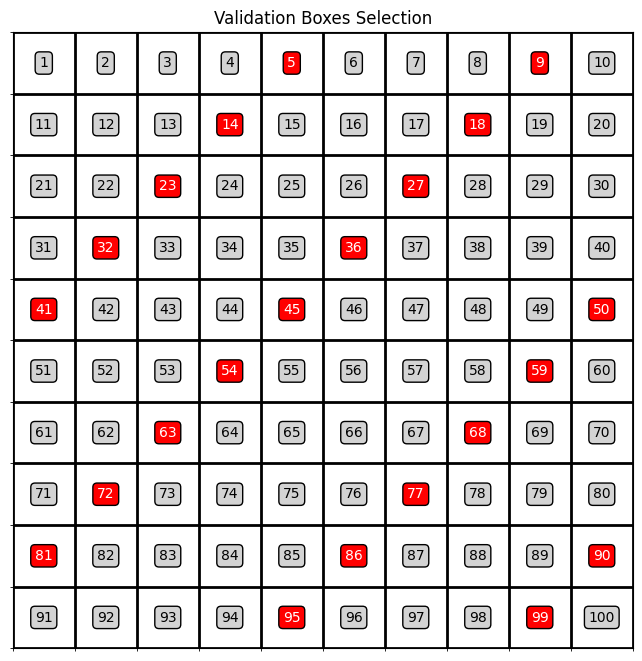

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 10x10 격자에서 1부터 100까지 박스 번호 생성 (책 읽는 순서로)
grid_size = 10
box_numbers = np.arange(1, 101).reshape((grid_size, grid_size), order='C')[::-1]

# 테스트 필터 정의
test_filter = lambda box_number: (box_number % 9 == 0 or box_number % 9 == 5)

# 테스트할 박스 선택
test_boxes = np.vectorize(test_filter)(box_numbers)

# 시각화
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks(np.arange(grid_size + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(grid_size + 1) - 0.5, minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

# 박스에 숫자 표시 및 색상 적용
for i in range(grid_size):
    for j in range(grid_size):
        box_number = box_numbers[i, j]
        ax.text(j, i, str(box_number), ha='center', va='center', fontsize=10, 
                color='white' if test_boxes[i, j] else 'black', 
                bbox=dict(facecolor='red' if test_boxes[i, j] else 'lightgray', 
                          edgecolor='black', boxstyle='round,pad=0.3'))

# 축을 숨김
ax.set_xticks([])
ax.set_yticks([])

plt.title("Validation Boxes Selection")
plt.show()


### 데이터 전처리 방법 설정 - naive

In [5]:
# 이미지 전처리 (Naive)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
])

## B, G, R, NIR 데이터만 사용

In [6]:
train_dataset = TiffDataset(
    large_tif_dir = os.path.join(source_data_dir,"naive"),
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = label_file_path,
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform
)

val_dataset = TiffDataset(
    large_tif_dir = os.path.join(source_data_dir,"naive"),
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = label_file_path,
    box_filter_fn = test_filter,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Epoch 1/1 - Training:   0%|          | 0/3683 [00:00<?, ?it/s]

Epoch 1/1 - Validation: 100%|██████████| 1163/1163 [00:18<00:00, 61.46it/s]



Epoch [1/1], Train Loss: 0.5021, Train Accuracy: 81.26%, Val Loss: 0.5533, Val Accuracy: 80.11%


train data


Evaluation Progress: 100%|██████████| 3683/3683 [01:00<00:00, 60.88it/s]


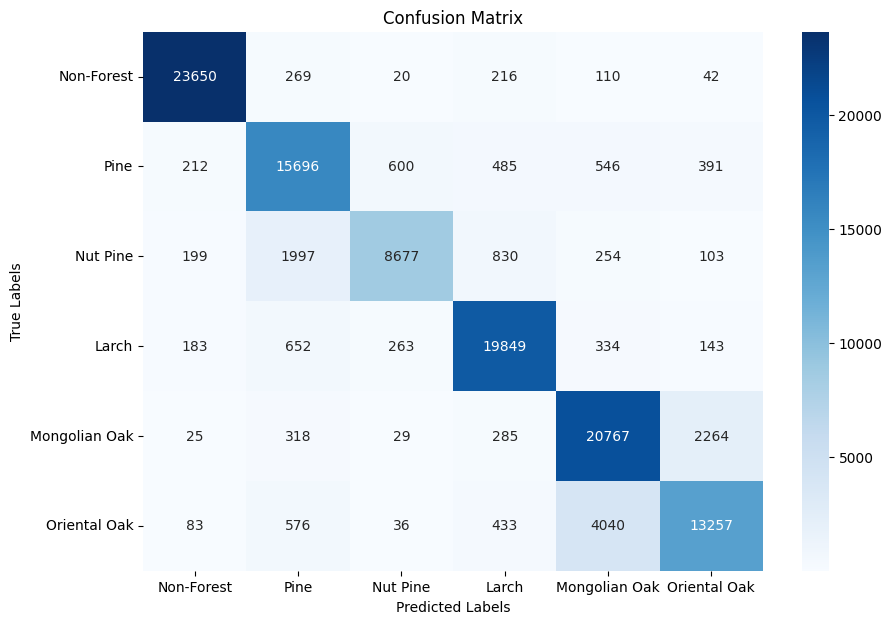

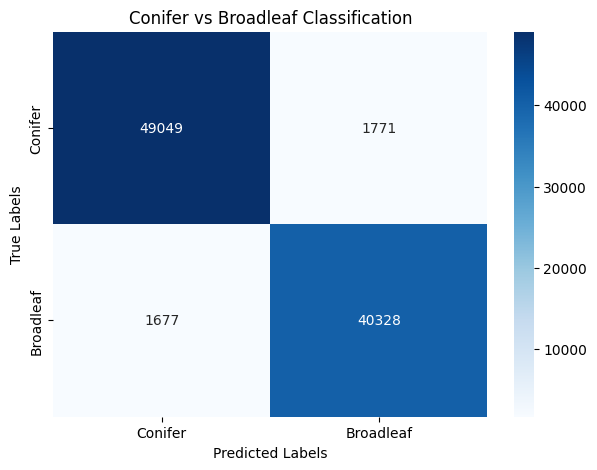

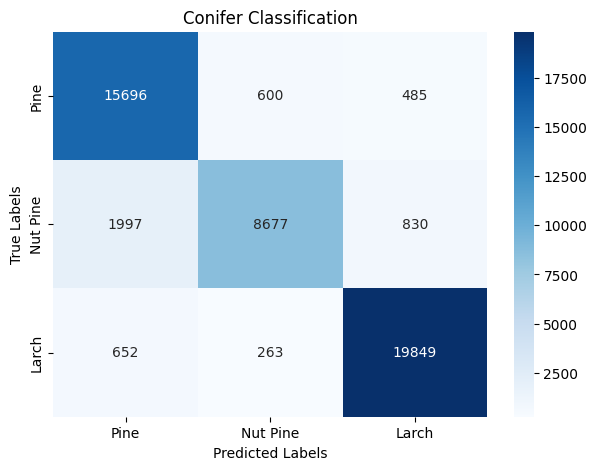

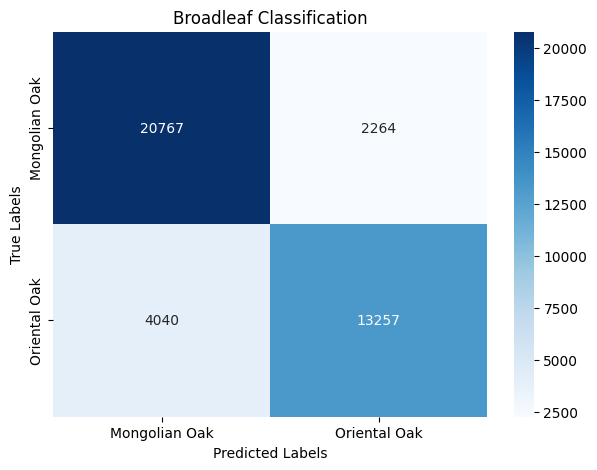


validation data


Evaluation Progress: 100%|██████████| 1163/1163 [00:18<00:00, 62.11it/s]


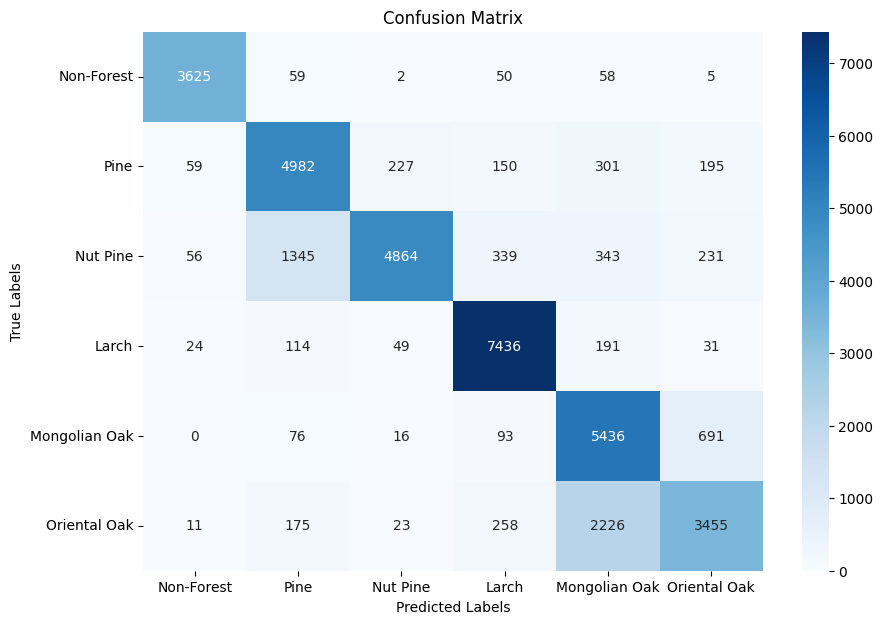

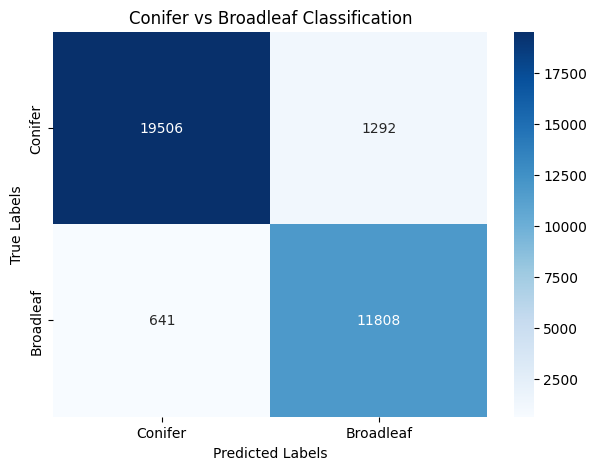

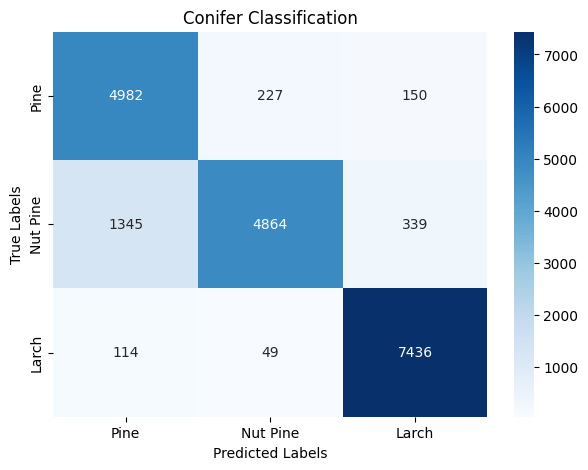

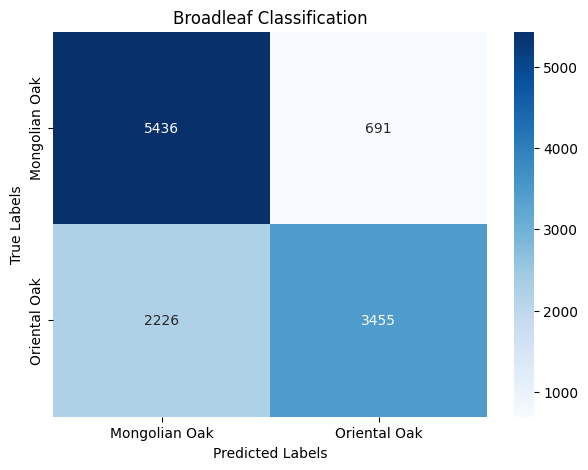

,precision,recall,f1-score,support,Category
Non-Forest,0.960265,0.954198,0.957222,3799.000000,Overall
Pine,0.737965,0.842408,0.786735,5914.000000,Overall
Nut Pine,0.938815,0.677626,0.787119,7178.000000,Overall
Larch,0.893106,0.947865,0.919671,7845.000000,Overall
Mongolian Oak,0.635418,0.861217,0.731284,6312.000000,Overall
Oriental Oak,0.749783,0.561971,0.642432,6148.000000,Overall
accuracy,0.801108,0.801108,0.801108,0.801108,Overall
macro avg,0.819225,0.807548,0.804077,37196.000000,Overall
weighted avg,0.816701,0.801108,0.798998,37196.000000,Overall
Conifer,0.968184,0.937879,0.952790,20798.000000,Conifer vs Broadleaf


In [7]:
model = ResNetLike(input_channels=48, num_classes=6).to(device)
model.apply(he_init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=1, patience=100
)
#os.makedirs("./checkpoints/image_classification",exist_ok=True)
#torch.save(best_model_state, "./checkpoints/image_classification/ResNetLike_48_3_100.pth")

model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

## NDVI도 추가된 데이터 사용

In [8]:
train_dataset = TiffDataset(
    large_tif_dir = os.path.join(source_data_dir,"with_ndvi"),
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = label_file_path,
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform
)

val_dataset = TiffDataset(
    large_tif_dir = os.path.join(source_data_dir,"with_ndvi"),
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = label_file_path,
    box_filter_fn = test_filter,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Epoch 1/1 - Validation: 100%|██████████| 1163/1163 [00:22<00:00, 51.92it/s]



Epoch [1/1], Train Loss: 0.4922, Train Accuracy: 81.70%, Val Loss: 0.5542, Val Accuracy: 81.07%


train data


Evaluation Progress: 100%|██████████| 3683/3683 [01:07<00:00, 54.73it/s]


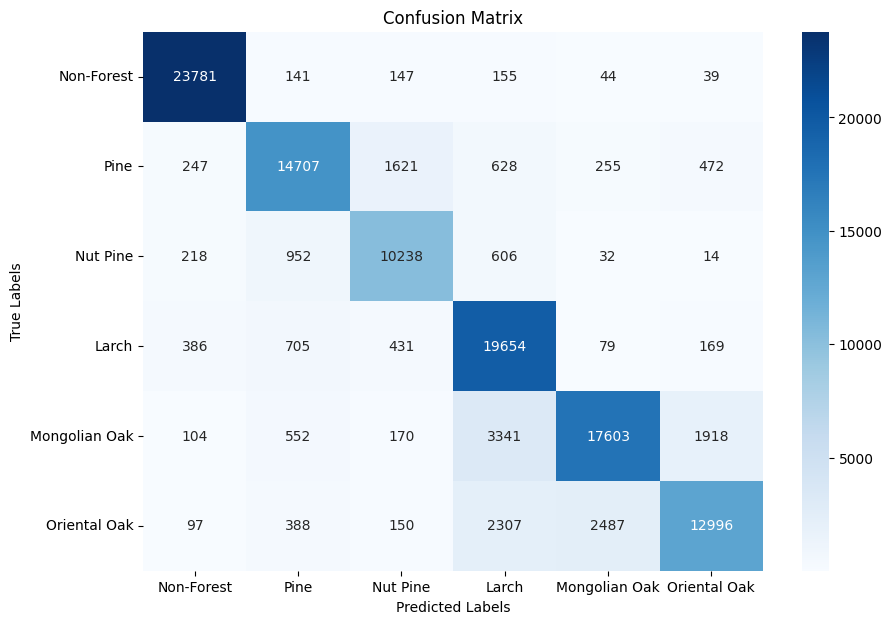

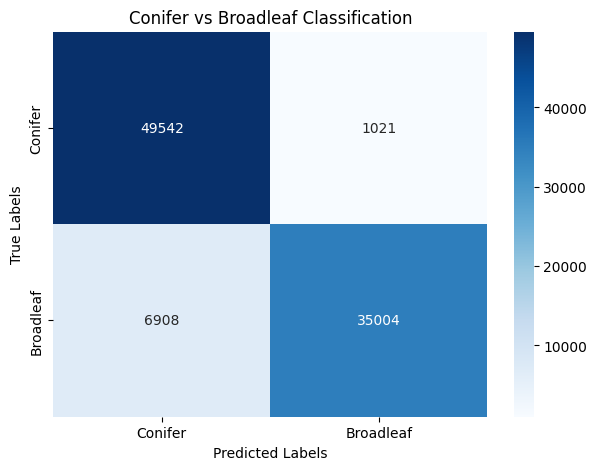

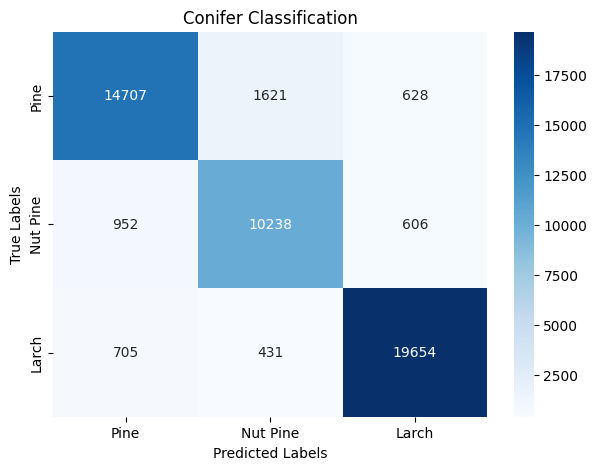

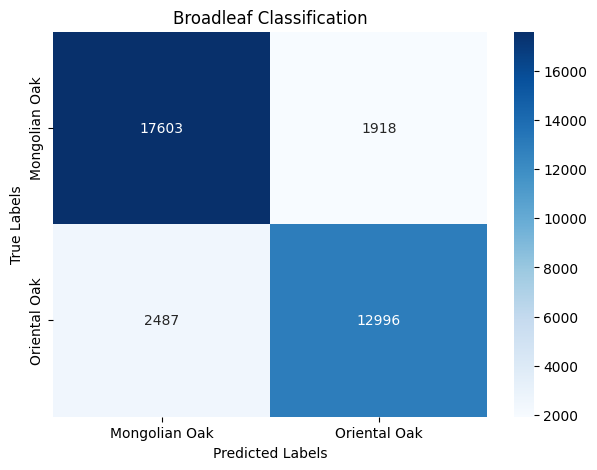


validation data


Evaluation Progress: 100%|██████████| 1163/1163 [00:21<00:00, 55.23it/s]


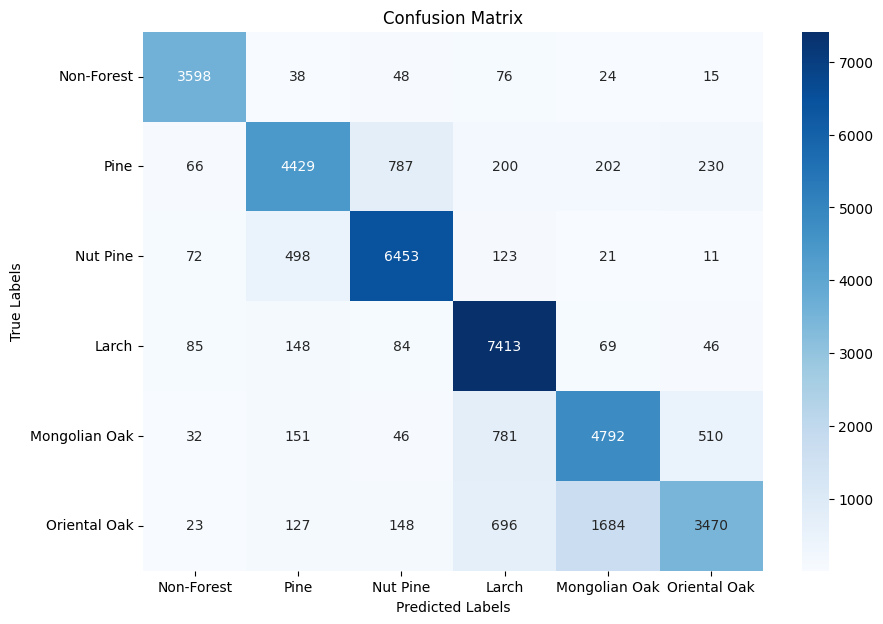

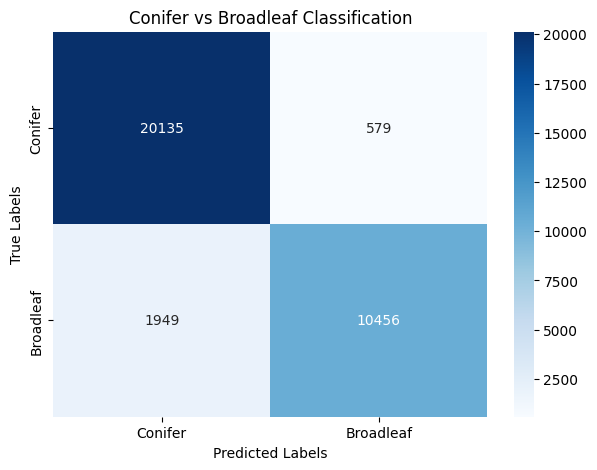

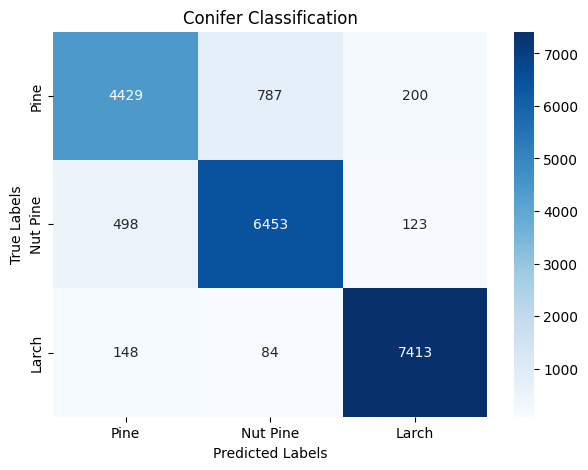

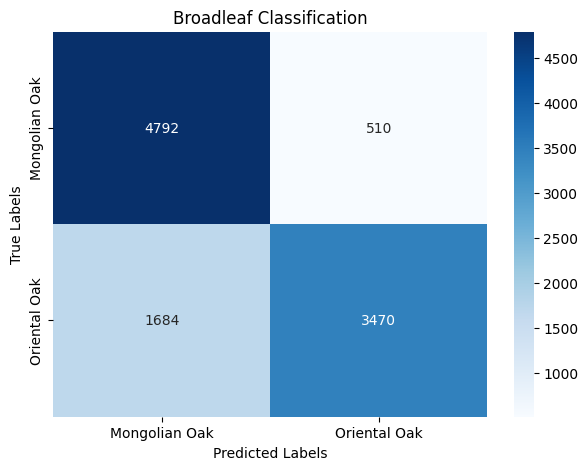

,precision,recall,f1-score,support,Category
Non-Forest,0.928277,0.947091,0.937590,3799.000000,Overall
Pine,0.821554,0.748901,0.783547,5914.000000,Overall
Nut Pine,0.852895,0.898997,0.875339,7178.000000,Overall
Larch,0.798041,0.944933,0.865297,7845.000000,Overall
Mongolian Oak,0.705536,0.759189,0.731380,6312.000000,Overall
Oriental Oak,0.810369,0.564411,0.665388,6148.000000,Overall
accuracy,0.810705,0.810705,0.810705,0.810705,Overall
macro avg,0.819445,0.810587,0.809757,37196.000000,Overall
weighted avg,0.812006,0.810705,0.805853,37196.000000,Overall
Conifer,0.911746,0.972048,0.940932,20714.000000,Conifer vs Broadleaf


In [9]:
model = ResNetLike(input_channels=60, num_classes=6).to(device)
model.apply(he_init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=1, patience=100
)
#torch.save(best_model_state, "./checkpoints/image_classification/ResNetLike_60_3_100.pth")

model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

## Sentinel_2 데이터도 추가하여 사용

In [11]:
train_dataset = TiffDataset(
    large_tif_dir = os.path.join(source_data_dir,"with_ndvi_s2"),
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = label_file_path,
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform
)

val_dataset = TiffDataset(
    large_tif_dir = os.path.join(source_data_dir,"with_ndvi_s2"),
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = label_file_path,
    box_filter_fn = test_filter,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Epoch 1/1 - Validation: 100%|██████████| 1163/1163 [00:22<00:00, 51.97it/s]



Epoch [1/1], Train Loss: 0.4385, Train Accuracy: 84.15%, Val Loss: 0.4517, Val Accuracy: 86.27%


train data


Evaluation Progress: 100%|██████████| 3683/3683 [01:09<00:00, 53.19it/s]


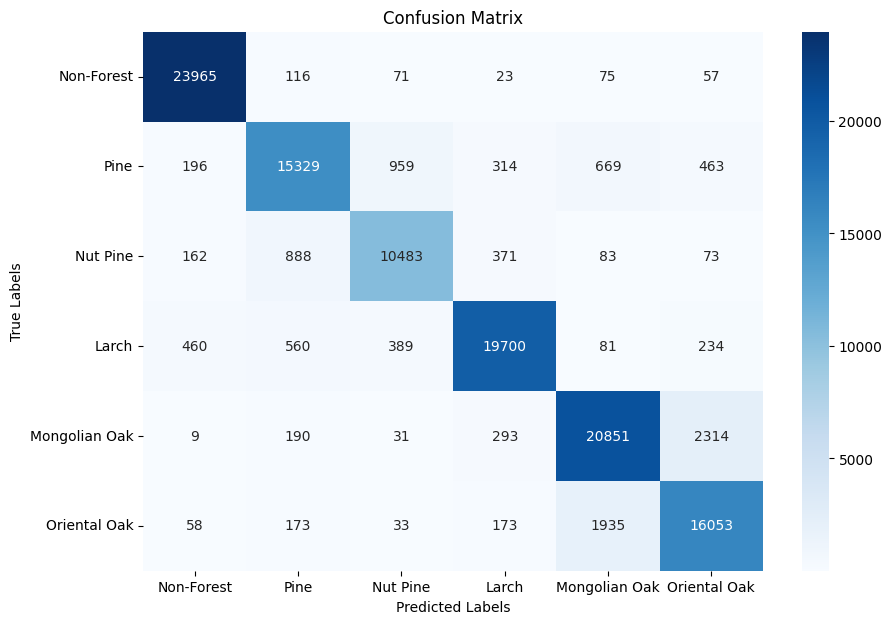

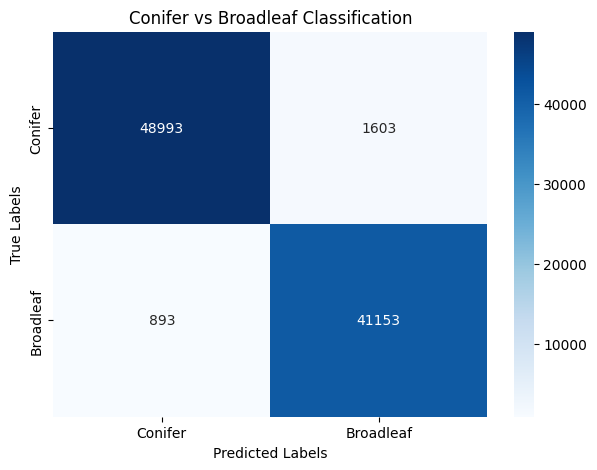

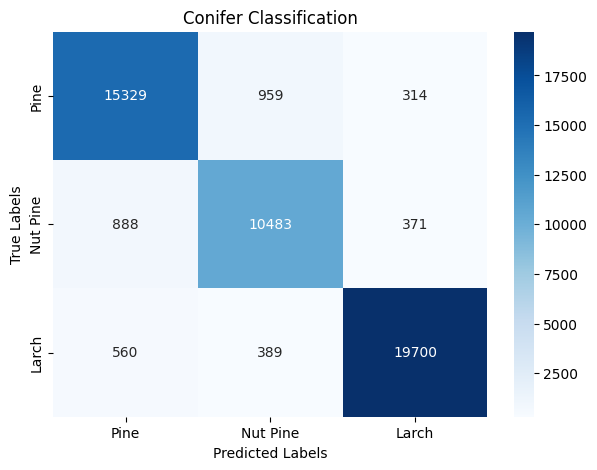

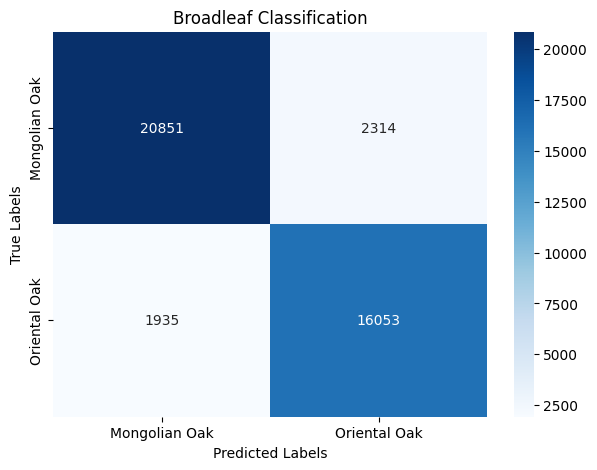


validation data


Evaluation Progress: 100%|██████████| 1163/1163 [00:21<00:00, 53.86it/s]


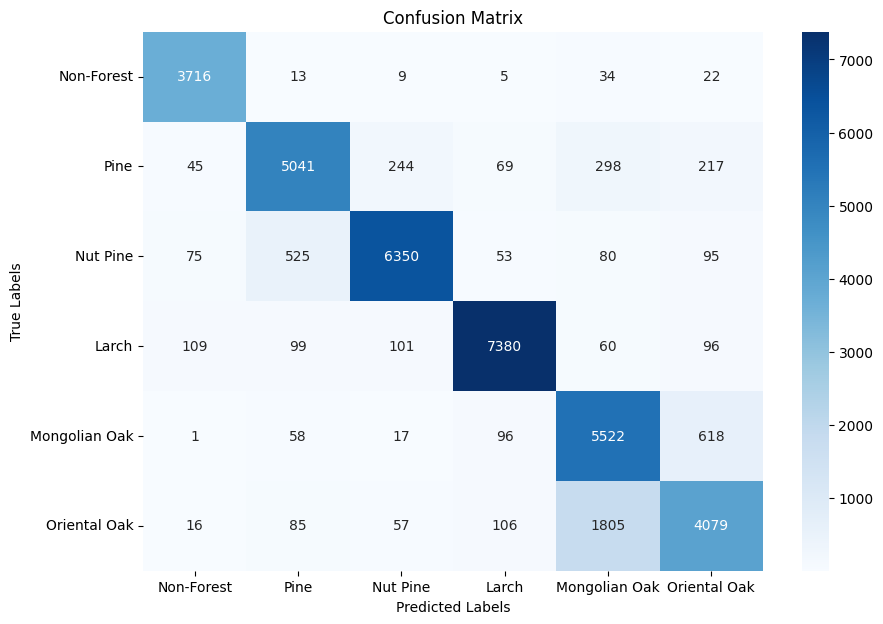

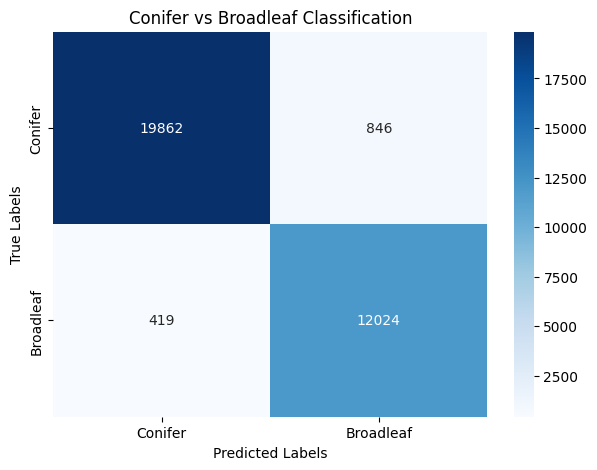

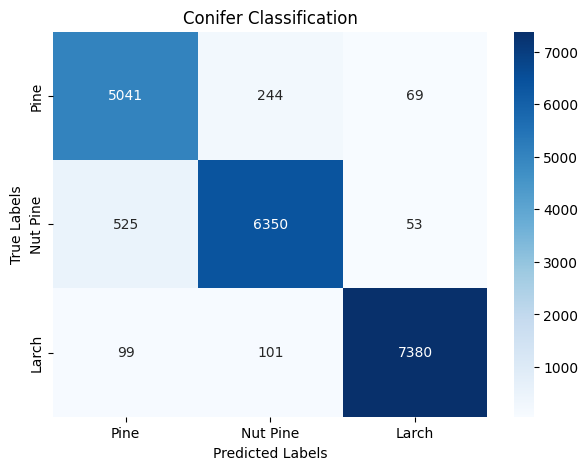

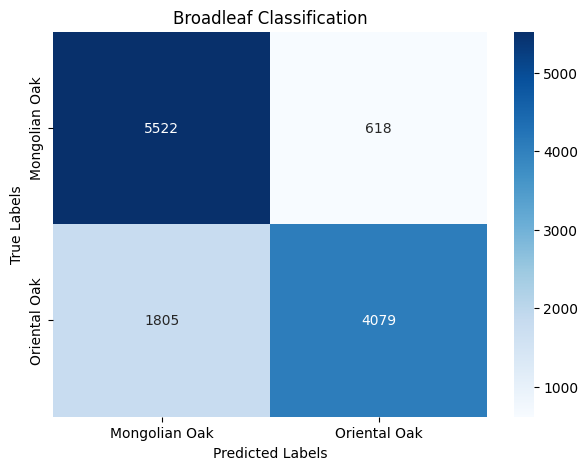

,precision,recall,f1-score,support,Category
Non-Forest,0.937910,0.978152,0.957609,3799.000000,Overall
Pine,0.866002,0.852384,0.859139,5914.000000,Overall
Nut Pine,0.936855,0.884648,0.910003,7178.000000,Overall
Larch,0.957323,0.940727,0.948952,7845.000000,Overall
Mongolian Oak,0.708039,0.874842,0.782652,6312.000000,Overall
Oriental Oak,0.795592,0.663468,0.723548,6148.000000,Overall
accuracy,0.862673,0.862673,0.862673,0.862673,Overall
macro avg,0.866954,0.865703,0.863650,37196.000000,Overall
weighted avg,0.867836,0.862673,0.862563,37196.000000,Overall
Conifer,0.979340,0.959146,0.969138,20708.000000,Conifer vs Broadleaf


In [13]:
model = ResNetLike(input_channels=120, num_classes=6).to(device)
model.apply(he_init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=1, patience=100
)
#torch.save(best_model_state, "./checkpoints/image_classification/ResNetLike_120_3_100.pth")
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

## NDVI 없이 Planet + Sentinel_2 데이터 사용

In [14]:
train_dataset = TiffDataset(
    large_tif_dir = os.path.join(source_data_dir,"with_s2"),
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = label_file_path,
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform
)

val_dataset = TiffDataset(
    large_tif_dir = os.path.join(source_data_dir,"with_s2"),
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = label_file_path,
    box_filter_fn = test_filter,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Epoch 1/1 - Validation: 100%|██████████| 1163/1163 [00:30<00:00, 38.40it/s]



Epoch [1/1], Train Loss: 0.4461, Train Accuracy: 83.79%, Val Loss: 0.4147, Val Accuracy: 86.36%


train data


Evaluation Progress: 100%|██████████| 3683/3683 [01:12<00:00, 50.64it/s]


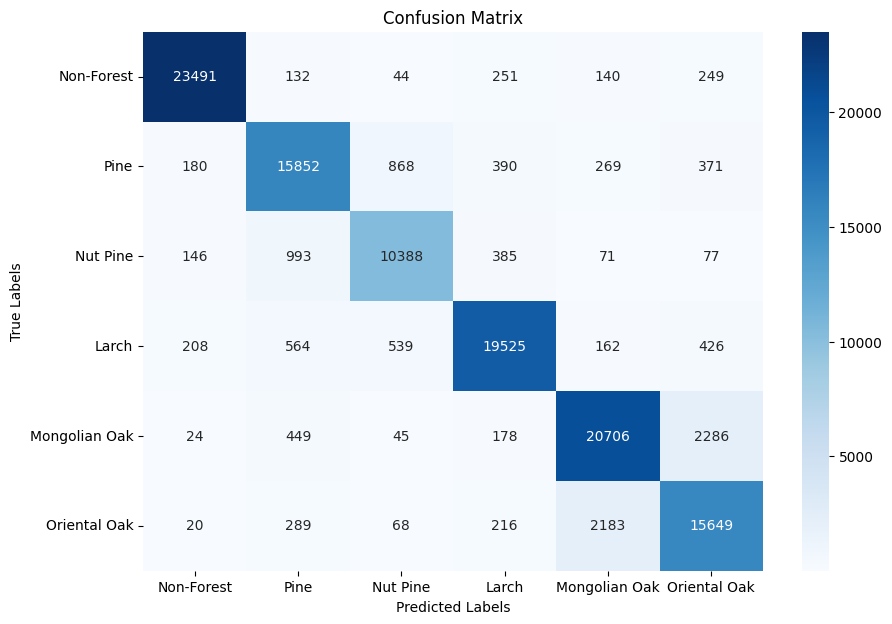

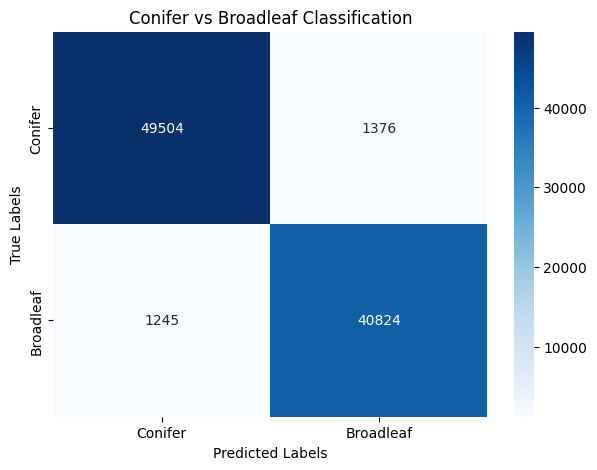

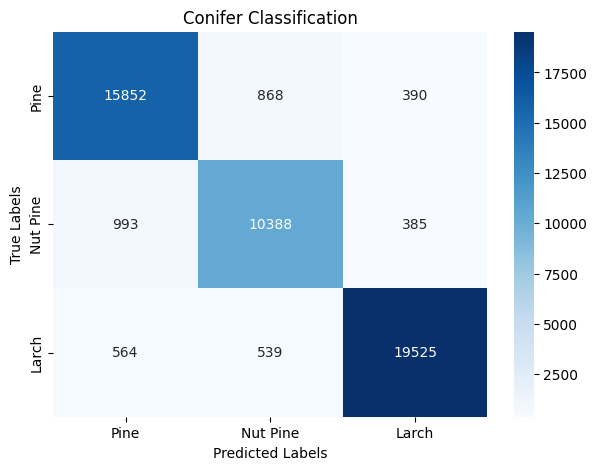

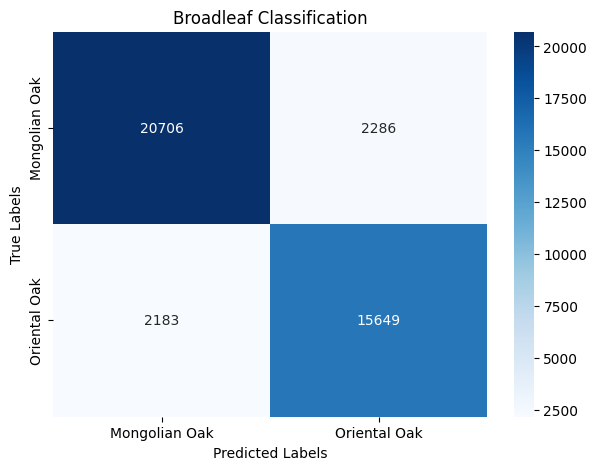


validation data


Evaluation Progress: 100%|██████████| 1163/1163 [00:22<00:00, 52.68it/s]


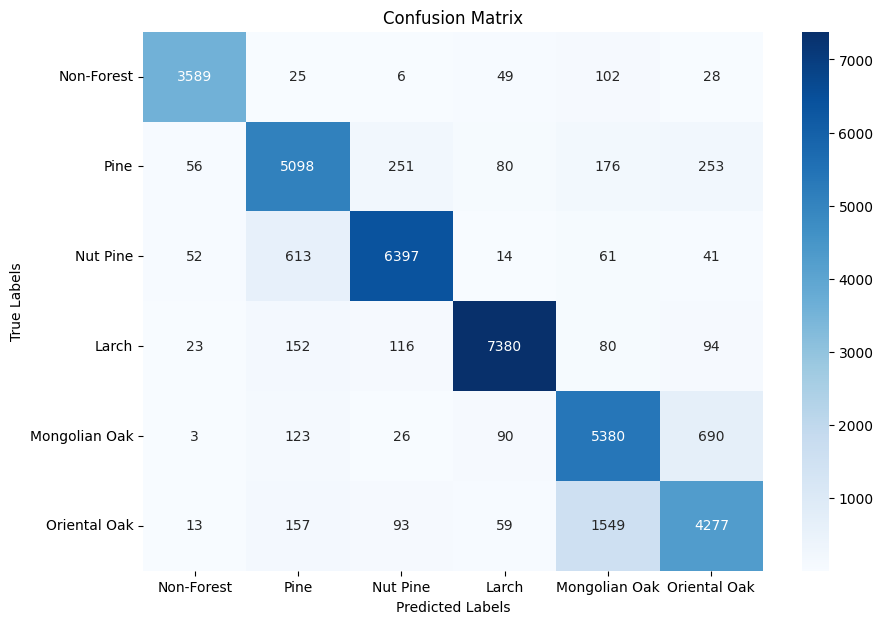

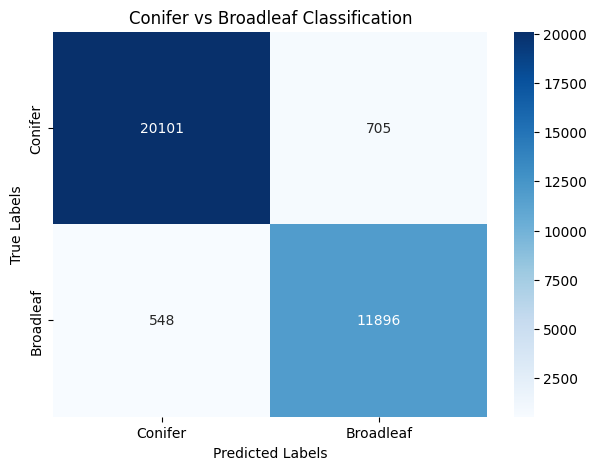

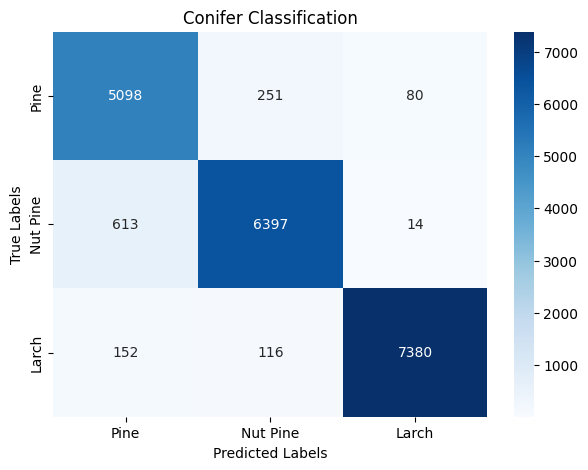

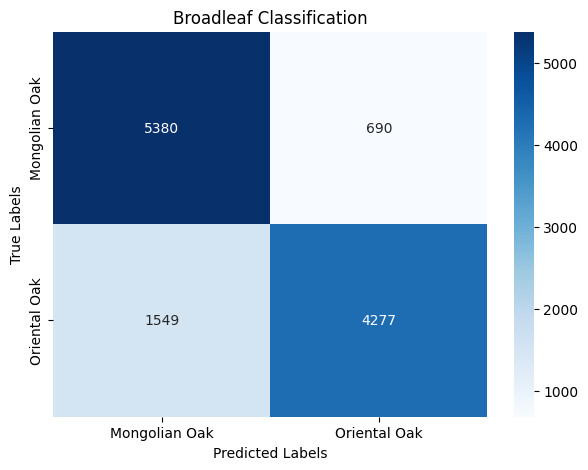

,precision,recall,f1-score,support,Category
Non-Forest,0.960653,0.944722,0.952621,3799.000000,Overall
Pine,0.826524,0.862022,0.843900,5914.000000,Overall
Nut Pine,0.928582,0.891195,0.909505,7178.000000,Overall
Larch,0.961940,0.940727,0.951215,7845.000000,Overall
Mongolian Oak,0.732172,0.852345,0.787701,6312.000000,Overall
Oriental Oak,0.794538,0.695673,0.741826,6148.000000,Overall
accuracy,0.863561,0.863561,0.863561,0.863561,Overall
macro avg,0.867401,0.864447,0.864461,37196.000000,Overall
weighted avg,0.867181,0.863561,0.863890,37196.000000,Overall
Conifer,0.973461,0.966116,0.969774,20806.000000,Conifer vs Broadleaf


In [15]:
model = ResNetLike(input_channels=108, num_classes=6).to(device)
model.apply(he_init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=1, patience=100
)
#torch.save(best_model_state, "./checkpoints/image_classification/ResNetLike_108_3_100.pth")
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)